In [1]:
## Avoiding Common Pitfalls When Clustering Biological Data
##  A guide to avoiding common pitfalls when clustering high-throughput biological data.
## Authors: Tom Ronan, Zhijie Qi, Kristen M. Naegle
##
## Supplemental Materials: iPython Notebook with data analysis and code 
## to generate toy data sets, and all toy and real data analysis.

## requires 'Common_Affy.txt' and 'Common_miRNA.txt' from Lu, et al. (2005), and 
## 'MRM_export_exp30_10_11_11_noStddev.txt' from Naegle, et al. (2009)

## Dependencies

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pylab
from matplotlib import colors
import matplotlib.patches as patches

import scipy.cluster.hierarchy as sch
import scipy.spatial.distance as ssd

from sklearn.decomposition import PCA as sklearnPCA
import sklearn.metrics.pairwise as pwdist
from mpl_toolkits.mplot3d import Axes3D

from sklearn import cluster, datasets
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from sklearn import mixture

from scipy.cluster.hierarchy import fcluster
import itertools as it

%matplotlib inline 

# change to reflect input file location
inputdir = '/home/tronan/Desktop/ronandev/ClusterReview/SecondSubmission/' 


### Data processing for Lu (2005)

## load mRNA
fileName = 'Common_Affy.txt'
raw_mRNA89 = pd.read_csv(fileName, sep='\t',skiprows=2)
raw_mRNA89.set_index('Name', inplace=True)
raw_mRNA89.drop('Description', axis=1, inplace=True)
raw_mRNA89_filtered=raw_mRNA89[~(raw_mRNA89<7.25).all(axis=1)]

## load miRNA
fileName = 'Common_miRNA.txt'
raw_miRNA89 = pd.read_csv(fileName, sep='\t',skiprows=2)
raw_miRNA89.set_index('Name', inplace=True)
raw_miRNA89.drop('Description', axis=1, inplace=True)
raw_miRNA89_filtered=raw_miRNA89[~(raw_miRNA89<7.25).all(axis=1)]


### Data Processing for Naegle (2009)

## load mRNA
fileName = 'MRM_export_exp30_10_11_11_noStddev.txt'
raw_phosprot = pd.read_csv(fileName, sep='\t',skiprows=0)
raw_phosprot.set_index(['gene_site','MS_id','pep'], inplace=True)
raw_phosprot.drop('run', axis=1, inplace=True)

# function necessary to plot subnested axes in matplotlib
def add_subplot_axes(ax,rect,axisbg='w'):
    fig = plt.gcf()
    box = ax.get_position()
    width = box.width
    height = box.height
    inax_position  = ax.transAxes.transform(rect[0:2])
    transFigure = fig.transFigure.inverted()
    infig_position = transFigure.transform(inax_position)    
    x = infig_position[0]
    y = infig_position[1]
    width *= rect[2]
    height *= rect[3]
    subax = fig.add_axes([x,y,width,height],axisbg=axisbg)
    
    return subax



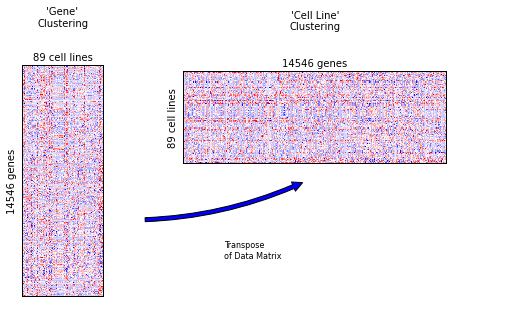

In [2]:
## Cluster Review Figure 1, Panels A and B
## Dimensionality

np.random.seed(7)
def randrange(n, vmin, vmax):
    return (vmax-vmin)*np.random.rand(n) + vmin


fig=plt.figure(figsize=(14,8))

## Data Schema

D2 = raw_mRNA89_filtered
D2_mc = D2.sub(D2.mean(axis=1),axis=0)
D2_norm = D2_mc.div(D2.std(axis=1),axis=0)
D2_norm.dropna(thresh=2, inplace=True)
D2_column_labels = D2.columns.tolist()


# Lu row diagram
axmatrix = fig.add_axes([0,0.5,.08,.4])
hm = D2_norm
im = axmatrix.matshow(hm, aspect='auto', origin='upper', cmap='bwr', vmin=-3, vmax=3)
axmatrix.set_xticks([])
axmatrix.set_yticks([])
axmatrix.set_title('\'Gene\'\nClustering', y=1.15,size=10)
axmatrix.set_ylabel(str(raw_mRNA89_filtered.shape[0])+' genes')
axmatrix.set_xlabel(str(raw_mRNA89_filtered.shape[1])+' cell lines')
axmatrix.xaxis.set_label_position('top') 

# Lu column diagram
axmatrix2 = fig.add_axes([.16,.73,.26,.16])
hm = D2_norm.transpose()
im = axmatrix2.matshow(hm, aspect='auto', origin='upper', cmap='bwr', vmin=-3, vmax=3)
axmatrix2.set_xticks([])
axmatrix2.set_yticks([])
axmatrix2.set_title('\'Cell Line\'\nClustering', y=1.4,size=10)
axmatrix2.set_ylabel(str(raw_mRNA89_filtered.shape[1])+' cell lines')
axmatrix2.set_xlabel(str(raw_mRNA89_filtered.shape[0])+' genes')
axmatrix2.xaxis.set_label_position('top') 


# Lu transpose arrow
ax_arrow = fig.add_axes([.08,0.5,.4,.22])
ax_arrow.axis('off')
p = patches.FancyArrowPatch(
    (0.10, 0.6),
    (0.50, 0.9),
    connectionstyle='arc3,rad=0.1',    # Default
    mutation_scale=20
    )
ax_arrow.add_patch(p)
ax_arrow.text(0.3,0.30,'Transpose\nof Data Matrix',fontsize=8)

plt.show()

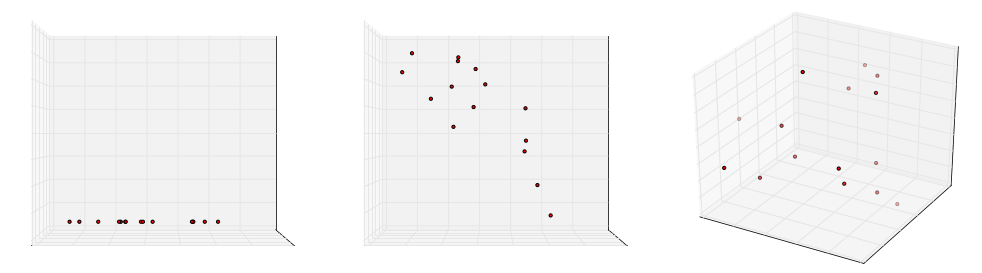

In [3]:
## Cluster Review Figure 1, Panel C
## Dimensionality and High-Dimensionality

fig=plt.figure(figsize=(14,8))

## Add Sparsity Axes
ax1 = fig.add_axes([0   ,0,0.3,0.45], projection='3d')
ax2 = fig.add_axes([0.33,0,0.3,0.45], projection='3d')
ax3 = fig.add_axes([0.66,0,0.3,0.45], projection='3d')

## Sparsity Plots

n = 5
size = 10

characteristics_array = [('r', 'o', size, 0.1, 0.3, 0.1, 0.5, 0.4, 0.7), ('r', 'o', size, 0.1, 0.4, 0.5, 1, 0.5, 0.7), ('r','o', size, 0.3, 0.6, 0.3, 0.6, 0.1, 0.5)]

for c, m, s, xl, xh, yl, yh, zl, zh in characteristics_array:

    xs = randrange(n, xl, xh)
    ys = randrange(n, yl, yh)
    zs = randrange(n, zl, zh)
    y0s = randrange(n, 0, 0)
    z0s = randrange(n, 0.1, 0.1)
    ax1.scatter(xs, y0s, z0s, s=s, c=c, marker=m)
    ax2.scatter(xs, y0s, zs, s=s, c=c, marker=m)
    ax3.scatter(xs, ys, zs, s=s, c=c, marker=m)

# make ticklabels and ticklines invisible

for axn in [ax1,ax2,ax3]:
    for a in axn.w_xaxis.get_ticklines()+axn.w_xaxis.get_ticklabels():
        a.set_visible(False) 
    for a in axn.w_yaxis.get_ticklines()+axn.w_yaxis.get_ticklabels():
        a.set_visible(False) 
    for a in axn.w_zaxis.get_ticklines()+axn.w_zaxis.get_ticklabels():
        a.set_visible(False)
    if axn == ax1 or axn == ax2:
        axn.dist+=-3
        axn.set_xlim(0,0.7)
        axn.set_ylim(0.3,0.8)
        axn.set_zlim(0,0.8)
        axn.elev=0
        axn.azim=270
    if axn == ax3:
        axn.dist+=-1
        axn.set_xlim(0,0.5)
        axn.set_ylim(0.3,0.8)
        axn.set_zlim(0,0.8)


plt.show()

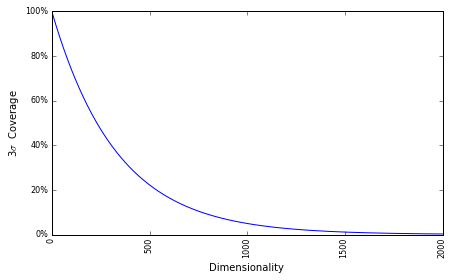

In [16]:
## Cluster Review Figure 1, Panel D
## Dimensionality

fig=plt.figure(figsize=(7,4))

## Add 3 sigma plot axis
ax4 = fig.add_subplot(111)

## 3 Sigma Coverage Plot
        
coverage = np.ones((2000,), dtype=np.int) * 0.997
plot_power = np.arange(1,2001)
plot_data = np.power(coverage,plot_power)
ax4.plot(plot_data)
ax4.set_xticklabels([0,500,1000,1500,2000],rotation=90,size=8)
ax4.set_yticklabels(['0%', '20%', '40%', '60%', '80%', '100%'],size=8)
ax4.set_xlabel('Dimensionality',size=10)
ax4.set_ylabel(r'3$\sigma$  Coverage',size=10)


plt.show()

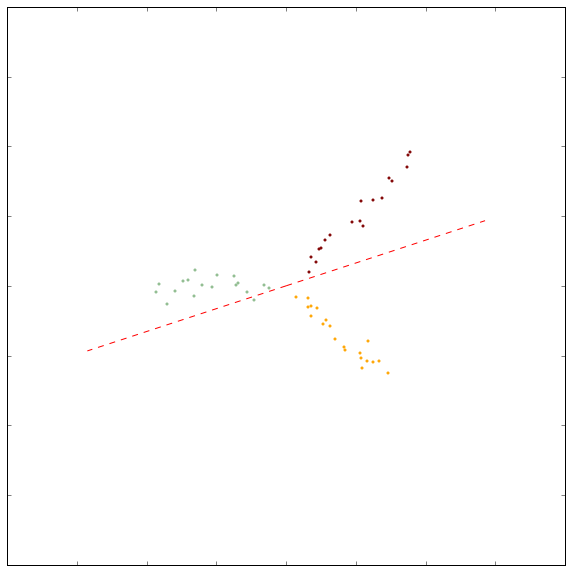

In [14]:
##Cluster Review Figure 2, Panel A
## Dimensionality Reduction


## Toy Dimensionality Reduction 
np.random.seed(0)

clust1_x = np.arange(-1,-0.1,0.05)
clust1_y = np.zeros(len(clust1_x))

clust2_x = np.arange(0.1,1,0.05)
clust2_y = np.arange(0.1,1,0.05)


clust3_x = np.arange(0.1,0.7,0.03)
clust3_y = -1 * np.arange(0.1,0.7,0.03)


cluster1_data = np.asarray([clust1_x+0.05*np.random.randn(len(clust1_x)),0.05*np.random.randn(len(clust1_x))+clust1_y])
cluster2_data = np.asarray([clust2_x+0.05*np.random.randn(len(clust2_x)),0.05*np.random.randn(len(clust2_x))+clust2_y])
cluster3_data = np.asarray([clust3_x+0.05*np.random.randn(len(clust3_x)),0.05*np.random.randn(len(clust3_x))+clust3_y])

fig=plt.figure(figsize=(10,10))

# original data space

ax = fig.add_subplot(111)
ax.scatter(cluster1_data[0],cluster1_data[1],s=4,color='darkseagreen')
ax.scatter(cluster2_data[0],cluster2_data[1],s=4,color='maroon')
ax.scatter(cluster3_data[0],cluster3_data[1],s=4,color='orange')
#ax.scatter(noisy_data[0],noisy_data[1],color='k')
ax.set_xlim(-2,2)
ax.set_ylim(-2,2)
ax.set_xticklabels([])
ax.set_yticklabels([])

# PCA projection
pca_data = np.hstack([cluster1_data,cluster2_data,cluster3_data]).T
pca = sklearnPCA(n_components=1)
pca_soln = pca.fit_transform(pca_data)
# plot direction of highest variance
ax.plot([0,pca.components_[0][0]*1.5],[0,pca.components_[0][1]*1.5],'--r')
ax.plot([0,-pca.components_[0][0]*1.5],[0,-pca.components_[0][1]*1.5],'--r')
ax.set_xlim(-2,2)
ax.set_ylim(-2,2)


plt.show()

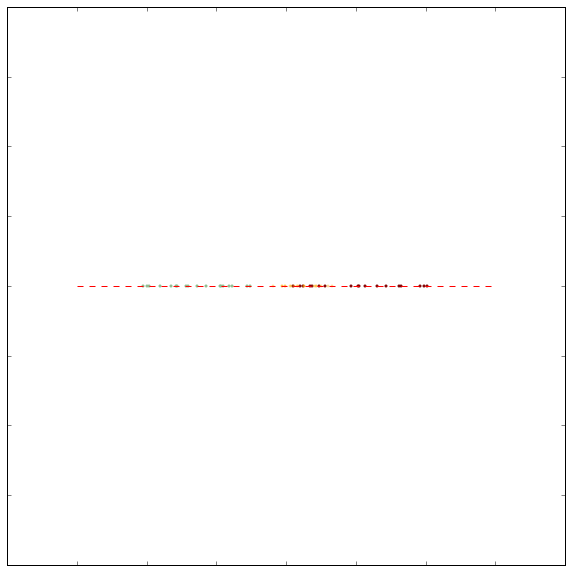

In [27]:
##Cluster Review Figure 2, Panel B
## Dimensionality Reduction

fig=plt.figure(figsize=(10,10))

# PCA dimensionality reduction
ax = fig.add_subplot(111)
ax.scatter(pca_soln[0:18], np.zeros(18), s=4, color='darkseagreen', alpha=1, label='Cluster1')
ax.scatter(pca_soln[18:36], np.zeros(18), s=4,color='maroon', alpha=1, label='Cluster2')
ax.scatter(pca_soln[36:54], np.zeros(18), s=4,color='orange', alpha=0.3, label='Cluster3')
#ax.scatter(pca_soln[54:79], np.zeros(25), color='k', alpha=0.5, label='Cluster4')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.plot([-1.5,1.5],[0,0],'--r')


plt.show()

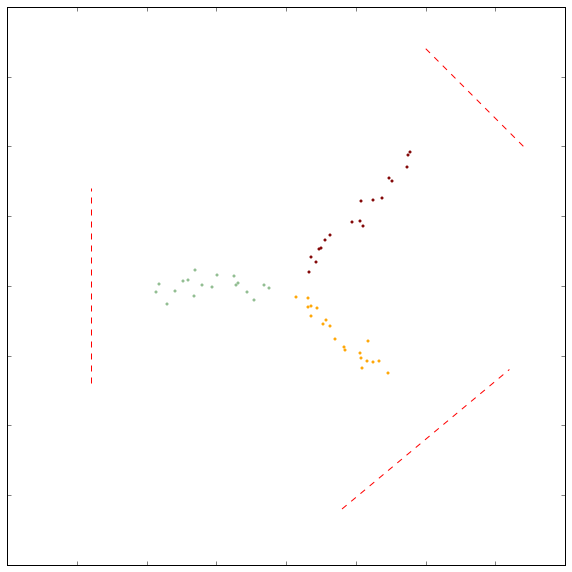

In [13]:
##Cluster Review Figure 2, Panel C
## Dimensionality Reduction


fig=plt.figure(figsize=(10,10))

# original data space

# subspaces marked
ax = fig.add_subplot(111)
ax.scatter(cluster1_data[0],cluster1_data[1],s=4,color='darkseagreen')
ax.scatter(cluster3_data[0],cluster3_data[1],s=4,color='orange')
ax.scatter(cluster2_data[0],cluster2_data[1],s=4,color='maroon')
#ax.scatter(noisy_data[0],noisy_data[1],color='k')
ax.set_xlim(-2,2)
ax.set_ylim(-2,2)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.plot([1.7,1],[1,1.7],'--r')
ax.plot([-1.4,-1.4],[-0.7,0.7],'--r')
ax.plot([0.4,1.6],[-1.6,-0.6],'--r')


plt.show()

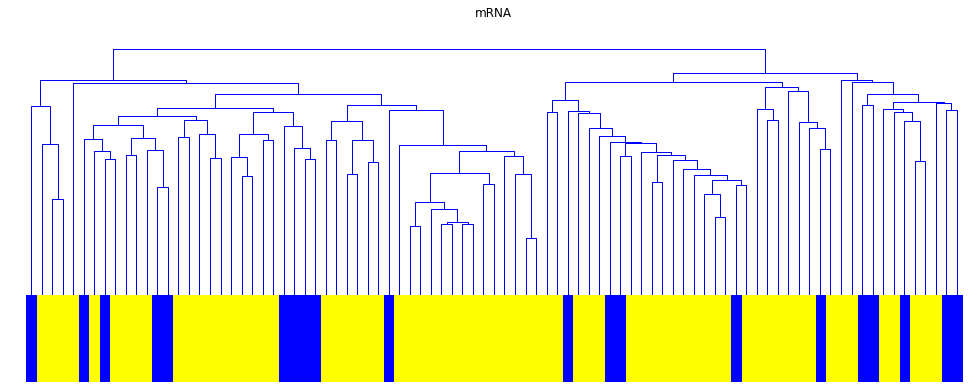

In [28]:
##Cluster Review Figure 2, Panel D
## Dimensionality Reduction

fig=plt.figure(figsize=(13,12))


## Dimensionality Reduction applied to Lu (2005) mRNA GI clustering results

#mRNA from Lu (2005)
D = raw_mRNA89_filtered
D_mc = D.sub(D.mean(axis=1),axis=0)
D_norm = D_mc.div(D.std(axis=1),axis=0)
D_norm.dropna(thresh=2, inplace=True)
D_mRNA_column_labels = D.columns.tolist()
D_mRNA = D_norm.transpose()

#mRNA after applying PCA
D = raw_mRNA89_filtered
D_mc = D.sub(D.mean(axis=1),axis=0)
D_norm = D_mc.div(D.std(axis=1),axis=0)
D_norm.dropna(thresh=2, inplace=True)
D_mRNApca_column_labels = D.columns.tolist()
pca_model = sklearnPCA(n_components=10)
pca_model.fit(D_norm.transpose())
D_mRNApca = pca_model.transform(D_norm.transpose())

#mRNA dim reduction (feature selection)
D = raw_mRNA89_filtered
D_mc = D.sub(D.mean(axis=1),axis=0)
D_norm = D_mc.div(D.std(axis=1),axis=0)
D_norm.dropna(thresh=2, inplace=True)
D_mRNAdimred_column_labels = D.columns.tolist()
mRNA_gi_dimension_list = [4914,7677,5373,3533,3786,9222,268,39,12017,9130]
D_mRNAdimred = D_norm.transpose().iloc[:,mRNA_gi_dimension_list]


# these are lists for the EP and GI tracks
GI_list = ['_LVR_','_COLON_','_STOM_','_PAN_']


###
### mRNA, as in Lu (2005)
###
# Compute and plot dendrogram, clustering cell lines for mRNA
ax_mRNA1 = fig.add_axes([0,0.1,1,.30])
lnk2 = sch.linkage(D_mRNA, method='average',metric='correlation')
Z_cl = sch.dendrogram(lnk2,color_threshold=0)
idx_cl = Z_cl['leaves']
ax_mRNA1.axis('off')
ax_mRNA1.set_title('mRNA\n')

# Add color strip to indicate GI status
ax_mRNA2 = fig.add_axes([0,0,1,0.10])
list_vals = [0 if any(cl in val for cl in GI_list) else 1 for val in D_mRNA_column_labels]
unsorted_list = np.array(list_vals)
sorted_list= unsorted_list[np.array(idx_cl)]
ax_mRNA2.matshow([sorted_list], aspect='auto', origin='lower', cmap = colors.ListedColormap(['blue', 'yellow']))
ax_mRNA2.axis('off')


plt.show()

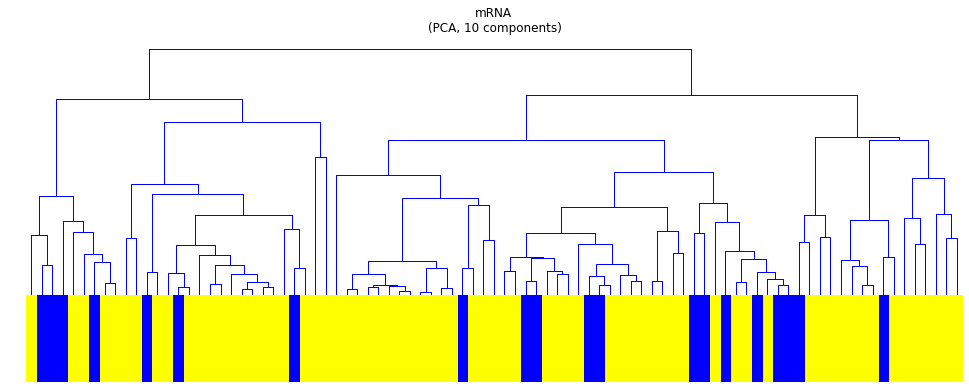

In [29]:
##Cluster Review Figure 2, Panels D, E, and F
## Dimensionality Reduction


fig=plt.figure(figsize=(13,12))


## Dimensionality Reduction applied to Lu (2005) mRNA GI clustering results

###
### mRNA after PCA
###

# Compute and plot dendrogram, clustering cell lines for mRNA
ax_D_mRNApca1 = fig.add_axes([0,0.1,1,0.30])
lnk2 = sch.linkage(D_mRNApca, method='average',metric='correlation')
Z_cl = sch.dendrogram(lnk2,color_threshold=0)
idx_cl = Z_cl['leaves']
ax_D_mRNApca1.axis('off')
ax_D_mRNApca1.set_title('mRNA\n(PCA, 10 components)')

# Add color strip to indicate GI status
ax_D_mRNApca2 = fig.add_axes([0,0,1,0.1])
list_vals = [0 if any(cl in val for cl in GI_list) else 1 for val in D_mRNApca_column_labels]
unsorted_list = np.array(list_vals)
sorted_list= unsorted_list[np.array(idx_cl)]
ax_D_mRNApca2.matshow([sorted_list], aspect='auto', origin='lower', cmap = colors.ListedColormap(['blue', 'yellow']))
ax_D_mRNApca2.axis('off')


plt.show()

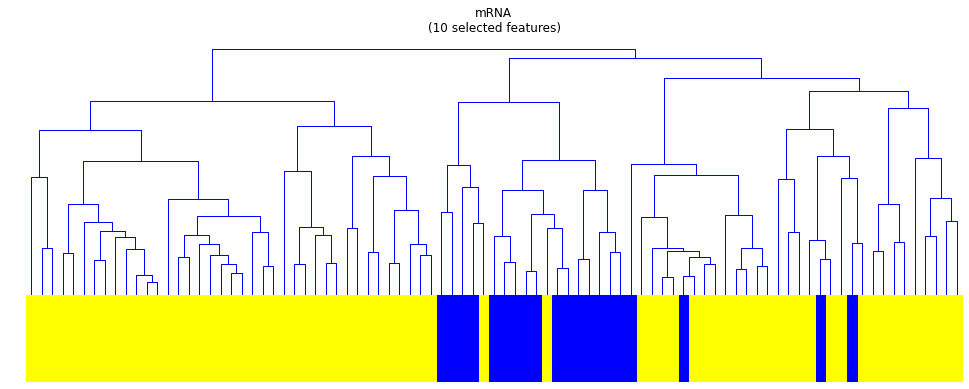

In [30]:
##Cluster Review Figure 2, Panels D, E, and F
## Dimensionality Reduction


fig=plt.figure(figsize=(13,12))


## Dimensionality Reduction applied to Lu (2005) mRNA GI clustering results

###
### mRNA after dimensionality reduction (feature selection)
###

# Compute and plot dendrogram, clustering cell lines for mRNA
ax_D_mRNAdimred1 = fig.add_axes([0,0.1,1,0.30])
lnk2 = sch.linkage(D_mRNAdimred, method='average',metric='correlation')
Z_cl = sch.dendrogram(lnk2,color_threshold=0)
idx_cl = Z_cl['leaves']
ax_D_mRNAdimred1.axis('off')
ax_D_mRNAdimred1.set_title('mRNA\n(10 selected features)')

# Add color strip to indicate GI status
ax_D_mRNAdimred2 = fig.add_axes([0,0,1,0.1])
list_vals = [0 if any(cl in val for cl in GI_list) else 1 for val in D_mRNAdimred_column_labels]
unsorted_list = np.array(list_vals)
sorted_list= unsorted_list[np.array(idx_cl)]
ax_D_mRNAdimred2.matshow([sorted_list], aspect='auto', origin='lower', cmap = colors.ListedColormap(['blue', 'yellow']))
ax_D_mRNAdimred2.axis('off')

plt.show()

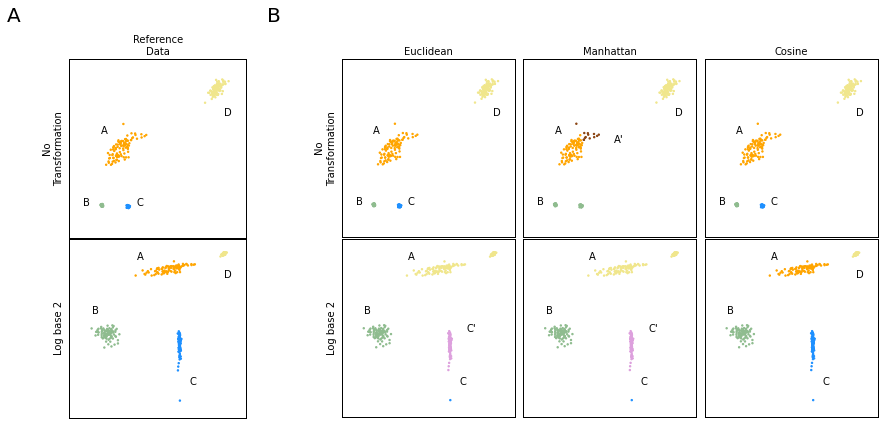

In [31]:
##Cluster Review Figure 3, Panels A and B
## Transformations and Distance Metrics

## Toy Transformation and Distance Metric Panel
np.random.seed(0)

# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
n_samples = 200

#create interesting data set
np.random.seed(1)
mean1 = [0.05,0.05]
cov1 = [[0.0001,0],[0,0.0001]] 
x1,y1 = np.random.multivariate_normal(mean1,cov1,n_samples/2).T
mean2 = [0.5,0.03]
cov2 = [[0.0001,0],[0,0.0001]] 
x2,y2 = np.random.multivariate_normal(mean2,cov2,n_samples/2).T
mean3 = [0.4,1]
cov3 = [[0.02,0.015],[0.015,0.02]] 
x3,y3 = np.random.multivariate_normal(mean3,cov3,n_samples/2).T
mean4 = [2,2]
cov4 = [[0.005,0.003],[0.003,0.005]] 
x4,y4 = np.random.multivariate_normal(mean4,cov4,n_samples/2).T


coordinates = np.transpose(np.vstack((np.hstack((x1,x2,x3,x4)), np.hstack((y1,y2,y3,y4)))))
categories = np.hstack((np.zeros(len(x1)),np.ones(len(x2)),1+np.ones(len(x3)),2+np.ones(len(x4))))
example_data = (coordinates,categories)



# dataset creation
X,y = example_data
X_raw = X
X_log2 = np.log2(X)
X_exp = np.exp(X)
X_Zscore = np.divide(X-np.mean(X),np.std(X))
X_range = np.divide(X-np.mean(X),np.max(X)-np.min(X))
X_vast = np.divide(X-np.mean(X),np.std(X))*np.divide(np.mean(X),np.std(X))

data_types = [X_raw, X_log2, X_exp]                     
y_names = ['No transformation','Log base 2','Exponential']

# create clustering estimators
agglom = cluster.AgglomerativeClustering(n_clusters=4, linkage='average')
agglom_manhattan = cluster.AgglomerativeClustering(n_clusters=4, linkage='average',affinity="manhattan")
agglom_cosine = cluster.AgglomerativeClustering(n_clusters=4, linkage='average',affinity="cosine")

clustering_algorithms = ['gold',agglom,agglom_manhattan,agglom_cosine]
x_names = ['Actual Clusters','Euclidean','Manhattan','Cosine']



fig=plt.figure(figsize=(13,13))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,hspace=.01)


# no transformation, no clustering
clustcolors = np.array(['darkseagreen','dodgerblue','orange','khaki'])
ax = plt.subplot2grid((10,10), (0,1), colspan=2, rowspan=2)
y_pred = np.asarray(y).astype(int)
ax.set_title('Reference \nData', size=10)
ax.set_ylabel('No \nTransformation')
ax.scatter(X[:, 0], X[:, 1], color=clustcolors[y_pred].tolist(), s=2)
ax.set_xticks(())
ax.set_yticks(())

ax.text(0.2,0.6,'A', ha='center', va='center',  transform=ax.transAxes, fontsize=10)
ax.text(0.1,0.2,'B', ha='center', va='center',  transform=ax.transAxes, fontsize=10)
ax.text(0.4,0.2,'C', ha='center', va='center',  transform=ax.transAxes, fontsize=10)
ax.text(0.9,0.7,'D', ha='center', va='center',  transform=ax.transAxes, fontsize=10)


# log base2, no clustering
clustcolors = np.array(['darkseagreen','dodgerblue','orange','khaki'])
ax = plt.subplot2grid((10,10), (2,1), colspan=2, rowspan=2)
y_pred = np.asarray(y).astype(int)
ax.set_ylabel('Log base 2')
ax.scatter(X_log2[:, 0], X_log2[:, 1], color=clustcolors[y_pred].tolist(), s=2)
ax.set_xticks(())
ax.set_yticks(())

ax.text(0.4,0.9,'A', ha='center', va='center',  transform=ax.transAxes, fontsize=10)
ax.text(0.15,0.6,'B', ha='center', va='center',  transform=ax.transAxes, fontsize=10)
ax.text(0.7,0.2,'C', ha='center', va='center',  transform=ax.transAxes, fontsize=10)
ax.text(0.9,0.8,'D', ha='center', va='center',  transform=ax.transAxes, fontsize=10)




# no transformation Euclidean
clustcolors = np.array(['orange','khaki','dodgerblue','darkseagreen'])
ax = plt.subplot(5,5,3)
ax.set_ylabel('No \nTransformation')
agglom.fit(X)
if hasattr(agglom, 'labels_'):
    y_pred = agglom.labels_.astype(np.int)
else:
    y_pred = agglom.predict(X)
ax.set_title('Euclidean', size=10)
ax.scatter(X[:, 0], X[:, 1], color=clustcolors[y_pred].tolist(), s=2)
ax.set_xticks(())
ax.set_yticks(())

ax.text(0.2,0.6,'A', ha='center', va='center',  transform=ax.transAxes, fontsize=10)
ax.text(0.1,0.2,'B', ha='center', va='center',  transform=ax.transAxes, fontsize=10)
ax.text(0.4,0.2,'C', ha='center', va='center',  transform=ax.transAxes, fontsize=10)
ax.text(0.9,0.7,'D', ha='center', va='center',  transform=ax.transAxes, fontsize=10)



# log base2, Euclidean
clustcolors = np.array(['khaki','plum','dodgerblue','darkseagreen','k','k','k'])
ax = plt.subplot(5,5,8)
ax.set_ylabel('Log base 2')
agglom.fit(X_log2)
if hasattr(agglom, 'labels_'):
    y_pred = agglom.labels_.astype(np.int)
else:
    y_pred = agglom.predict(X)
ax.scatter(X_log2[:, 0], X_log2[:, 1], color=clustcolors[y_pred].tolist(), s=2)
ax.set_xticks(())
ax.set_yticks(())

ax.text(0.4,0.9,'A', ha='center', va='center',  transform=ax.transAxes, fontsize=10)
ax.text(0.15,0.6,'B', ha='center', va='center',  transform=ax.transAxes, fontsize=10)
ax.text(0.7,0.2,'C', ha='center', va='center',  transform=ax.transAxes, fontsize=10)
ax.text(0.75,0.5,'C\'', ha='center', va='center',  transform=ax.transAxes, fontsize=10)
#ax.text(0.9,0.8,'D', ha='center', va='center',  transform=ax.transAxes, fontsize=10)




# no transformation Manhattan
clustcolors = np.array(['darkseagreen','khaki','saddlebrown','orange'])

ax = plt.subplot(5,5,4)
agglom_manhattan.fit(X)
if hasattr(agglom_manhattan, 'labels_'):
    y_pred = agglom_manhattan.labels_.astype(np.int)
else:
    y_pred = agglom_manhattan.predict(X)
ax.set_title('Manhattan', size=10)
ax.scatter(X[:, 0], X[:, 1], color=clustcolors[y_pred].tolist(), s=2)
ax.set_xticks(())
ax.set_yticks(())

ax.text(0.2,0.6,'A', ha='center', va='center',  transform=ax.transAxes, fontsize=10)
ax.text(0.55,0.55,'A\'', ha='center', va='center',  transform=ax.transAxes, fontsize=10)
ax.text(0.1,0.2,'B', ha='center', va='center',  transform=ax.transAxes, fontsize=10)
#ax.text(0.4,0.2,'C', ha='center', va='center',  transform=ax.transAxes, fontsize=10)
ax.text(0.9,0.7,'D', ha='center', va='center',  transform=ax.transAxes, fontsize=10)

# log base2, Manhattan
clustcolors = np.array(['khaki','plum','darkseagreen','dodgerblue'])

ax = plt.subplot(5,5,9)
agglom_manhattan.fit(X_log2)
if hasattr(agglom_manhattan, 'labels_'):
    y_pred = agglom_manhattan.labels_.astype(np.int)
else:
    y_pred = agglom_manhattan.predict(X)
ax.scatter(X_log2[:, 0], X_log2[:, 1], color=clustcolors[y_pred].tolist(), s=2)
ax.set_xticks(())
ax.set_yticks(())

ax.text(0.4,0.9,'A', ha='center', va='center',  transform=ax.transAxes, fontsize=10)
ax.text(0.15,0.6,'B', ha='center', va='center',  transform=ax.transAxes, fontsize=10)
ax.text(0.7,0.2,'C', ha='center', va='center',  transform=ax.transAxes, fontsize=10)
ax.text(0.75,0.5,'C\'', ha='center', va='center',  transform=ax.transAxes, fontsize=10)
#ax.text(0.9,0.8,'D', ha='center', va='center',  transform=ax.transAxes, fontsize=10)

# no transformation Cosine
clustcolors = np.array(['darkseagreen','dodgerblue','orange','khaki'])
ax = plt.subplot(5,5,5)
agglom_cosine.fit(X)
if hasattr(agglom_cosine, 'labels_'):
    y_pred = agglom_cosine.labels_.astype(np.int)
else:
    y_pred = agglom_cosine.predict(X)
y_pred = np.asarray(y).astype(int)
ax.set_title('Cosine', size=10)
ax.scatter(X[:, 0], X[:, 1], color=clustcolors[y_pred].tolist(), s=2)
ax.set_xticks(())
ax.set_yticks(())

ax.text(0.2,0.6,'A', ha='center', va='center',  transform=ax.transAxes, fontsize=10)
ax.text(0.1,0.2,'B', ha='center', va='center',  transform=ax.transAxes, fontsize=10)
ax.text(0.4,0.2,'C', ha='center', va='center',  transform=ax.transAxes, fontsize=10)
ax.text(0.9,0.7,'D', ha='center', va='center',  transform=ax.transAxes, fontsize=10)


# log base2, Cosine
clustcolors = np.array(['orange','dodgerblue','darkseagreen','khaki'])
ax = plt.subplot(5,5,10)
agglom_cosine.fit(X_log2)
if hasattr(agglom_cosine, 'labels_'):
    y_pred = agglom_cosine.labels_.astype(np.int)
else:
    y_pred = agglom_cosine.predict(X)
ax.scatter(X_log2[:, 0], X_log2[:, 1], color=clustcolors[y_pred].tolist(), s=2)
ax.set_xticks(())
ax.set_yticks(())

ax.text(0.4,0.9,'A', ha='center', va='center',  transform=ax.transAxes, fontsize=10)
ax.text(0.15,0.6,'B', ha='center', va='center',  transform=ax.transAxes, fontsize=10)
ax.text(0.7,0.2,'C', ha='center', va='center',  transform=ax.transAxes, fontsize=10)
ax.text(0.9,0.8,'D', ha='center', va='center',  transform=ax.transAxes, fontsize=10)


#######
###endplot
#######


fig.text(0.05,1,'A',fontsize=20)
fig.text(.33,1,'B',fontsize=20)
plt.show()

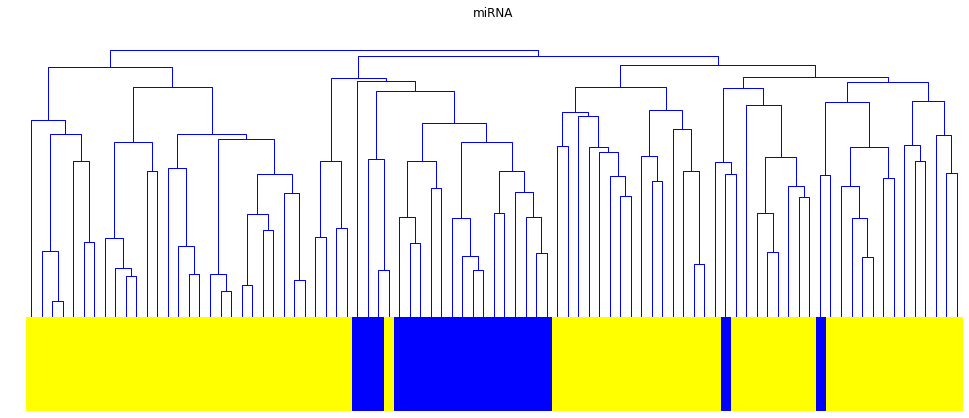

In [32]:
##Cluster Review Figure 3, Panel C
## Transformations and Distance Metrics

fig=plt.figure(figsize=(13,13))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,hspace=.01)


## Differential Clustering of GI cell lines from Lu (2005) based on Transformation

#miRNA from Lu (2005)
D = raw_miRNA89_filtered
D_mc = D.sub(D.mean(axis=1),axis=0)
D_norm = D_mc.div(D.std(axis=1),axis=0)
D_miRNA_column_labels = D.columns.tolist()
D_miRNA = D_norm.transpose()

#miRNA before log2 transformation
D = 2 ** raw_miRNA89_filtered
D_mc = D.sub(D.mean(axis=1),axis=0)
D_norm = D_mc.div(D.std(axis=1),axis=0)
D_norm.dropna(thresh=2, inplace=True)
D_miRNAprelog_column_labels = D.columns.tolist()
D_miRNAprelog = D_norm.transpose()


# these are lists for the EP and GI tracks
GI_list = ['_LVR_','_COLON_','_STOM_','_PAN_']


###
### miRNA, as in Lu (2005)
###

# Compute and plot dendrogram, clustering cell lines for miRNA
ax_miRNA1 = fig.add_axes([0,.1,1,.30])
lnk1 = sch.linkage(D_miRNA, method='average',metric='correlation')
Z_cl = sch.dendrogram(lnk1,color_threshold=0)
idx_cl = Z_cl['leaves']
ax_miRNA1.axis('off')
ax_miRNA1.set_title('miRNA\n')

# Add color strip to indicate GI status
ax_miRNA2 = fig.add_axes([0,0,1,0.1])
list_vals = [0 if any(cl in val for cl in GI_list) else 1 for val in D_miRNA_column_labels]
unsorted_list = np.array(list_vals)
sorted_list= unsorted_list[np.array(idx_cl)]
ax_miRNA2.matshow([sorted_list], aspect='auto', origin='lower', cmap = colors.ListedColormap(['blue', 'yellow']))
ax_miRNA2.axis('off')


plt.show()

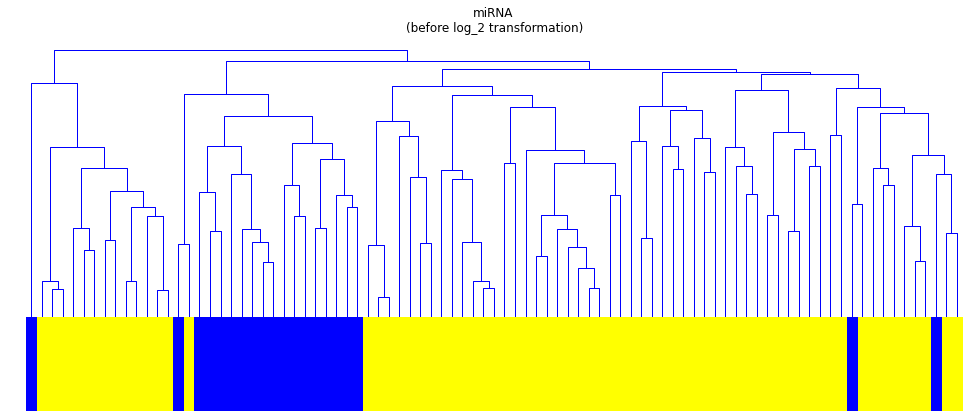

In [33]:
##Cluster Review Figure 3, Panel D
## Transformations and Distance Metrics

fig=plt.figure(figsize=(13,13))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,hspace=.01)

###
### miRNA before log transformation
###

# Compute and plot dendrogram, clustering cell lines for mRNA
ax_miRNA_prelog1 = fig.add_axes([0,.1,1,.30])
lnk2 = sch.linkage(D_miRNAprelog, method='average',metric='correlation')
Z_cl = sch.dendrogram(lnk2,color_threshold=0)
idx_cl = Z_cl['leaves']
ax_miRNA_prelog1.axis('off')
ax_miRNA_prelog1.set_title('miRNA\n(before log_2 transformation)')

# Add color strip to indicate GI status
ax_miRNA_prelog2 = fig.add_axes([0,0,1,0.1])
list_vals = [0 if any(cl in val for cl in GI_list) else 1 for val in D_miRNAprelog_column_labels]
unsorted_list = np.array(list_vals)
sorted_list= unsorted_list[np.array(idx_cl)]
ax_miRNA_prelog2.matshow([sorted_list], aspect='auto', origin='lower', cmap = colors.ListedColormap(['blue', 'yellow']))
ax_miRNA_prelog2.axis('off')


plt.show()

/usr/local/lib/python2.7/dist-packages/sklearn/cluster/hierarchical.py:205: UserWarning: the number of connected components of the connectivity matrix is 2 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_components = _fix_connectivity(X, connectivity)


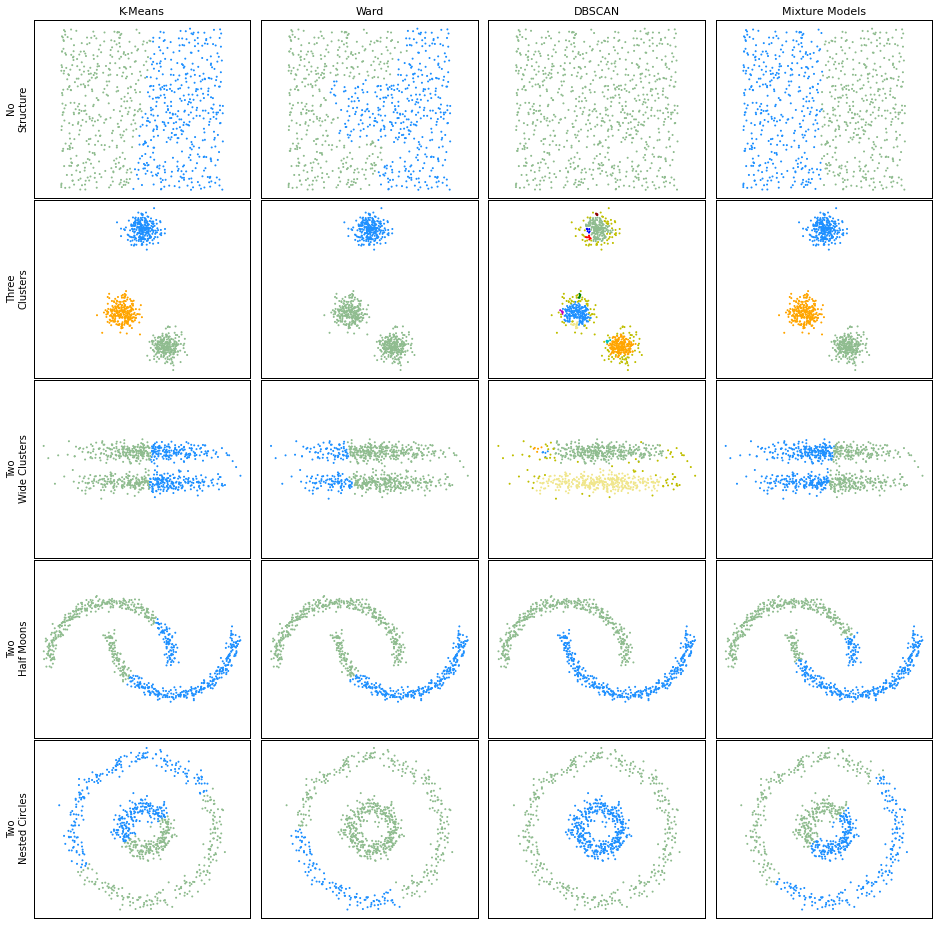

In [34]:
##Cluster Review Figure 4
## Algorithms
# adapted from Scikit Learn, "Comparing different clustering algorithms on toy datasets"
# found at http://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html

np.random.seed(0)

## Generate datasets.
n_samples = 800
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.3,noise=.07)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=10,centers=3,cluster_std=1)

#create noisy parallel lines
mean1 = [0,1]
cov1 = [[5,0],[0,0.1]] 
x1,y1 = np.random.multivariate_normal(mean1,cov1,n_samples/2).T
mean2 = [0,-1]
cov2 = [[5,0],[0,.1]] 
x2,y2 = np.random.multivariate_normal(mean2,cov2,n_samples/2).T
coordinates = np.transpose(np.vstack((np.hstack((x1,x2)), np.hstack((y1,y2)))))
categories = np.hstack((np.zeros(len(x1)),np.ones(len(y1))))
noisy_lines = (coordinates,categories)

#create data with no structure
no_structure = np.random.rand(n_samples, 2), None


clustcolors = np.array(['darkseagreen','dodgerblue','orange','khaki','darkred','b','g','r','c','m','y'])
clustcolors = np.hstack([clustcolors] * 20)

clustering_names = ['K-Means', 'Ward', 'DBSCAN', 'Mixture Models']

fig=plt.figure(figsize=(13, 13))

plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)
plot_num = 1

dataset_list = [no_structure, blobs, noisy_lines, noisy_moons, noisy_circles]
for i_dataset, dataset in enumerate(dataset_list):

    X, y = dataset

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=0.3)

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(X, n_neighbors=10, include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # create clustering estimators
    two_means = cluster.MiniBatchKMeans(n_clusters=2)
    three_means = cluster.MiniBatchKMeans(n_clusters=3)
    ward_two = cluster.AgglomerativeClustering(n_clusters=2, linkage='ward',connectivity=connectivity)
    ward_three = cluster.AgglomerativeClustering(n_clusters=3, linkage='ward',connectivity=connectivity)
    dbscan = cluster.DBSCAN(eps=.3)

    #mixture model results
    gmm2 = mixture.GMM(n_components=2, covariance_type='full')
    gmm3 = mixture.GMM(n_components=3, covariance_type='full')
    

    #clustering_algorithms = [two_means, affinity_propagation, ms, spectral, ward, average_linkage,dbscan, birch]
    clustering_algorithms = ['kmeans','ward','dbscan','mixturemodels']

    for name, algorithm_name in zip(clustering_names, clustering_algorithms):

        # predict cluster memberships
        if dataset is no_structure or dataset is noisy_lines or dataset is noisy_moons or dataset is noisy_circles:
            if algorithm_name == 'kmeans':
                algorithm = two_means
            if algorithm_name == 'ward':
                algorithm = ward_two
            if algorithm_name == 'dbscan':
                algorithm = dbscan
            if algorithm_name == 'mixturemodels':
                algorithm = gmm2
        if dataset is blobs:
            if algorithm_name == 'kmeans':
                algorithm = three_means
            if algorithm_name == 'ward':
                algorithm = ward_two
            if algorithm_name == 'dbscan':
                algorithm = dbscan
            if algorithm_name == 'mixturemodels':
                algorithm = gmm3
        
        
        algorithm.fit(X)
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)

        # plot
        ax = plt.subplot(len(dataset_list), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            ax.set_title(name, size=11)
        if plot_num == 1:
            ax.set_ylabel('No\nStructure')
        if plot_num == 5:
            ax.set_ylabel('Three\nClusters')
        if plot_num == 9:
            ax.set_ylabel('Two\nWide Clusters')
        if plot_num == 13:
            ax.set_ylabel('Two\nHalf Moons')
        if plot_num == 17:
            ax.set_ylabel('Two\nNested Circles')
            
            
        ax.scatter(X[:, 0], X[:, 1], color=clustcolors[y_pred].tolist(), s=1)

        ax.set_xticks(())
        ax.set_yticks(())
        ax.axis("equal")

        plot_num += 1

plt.show()

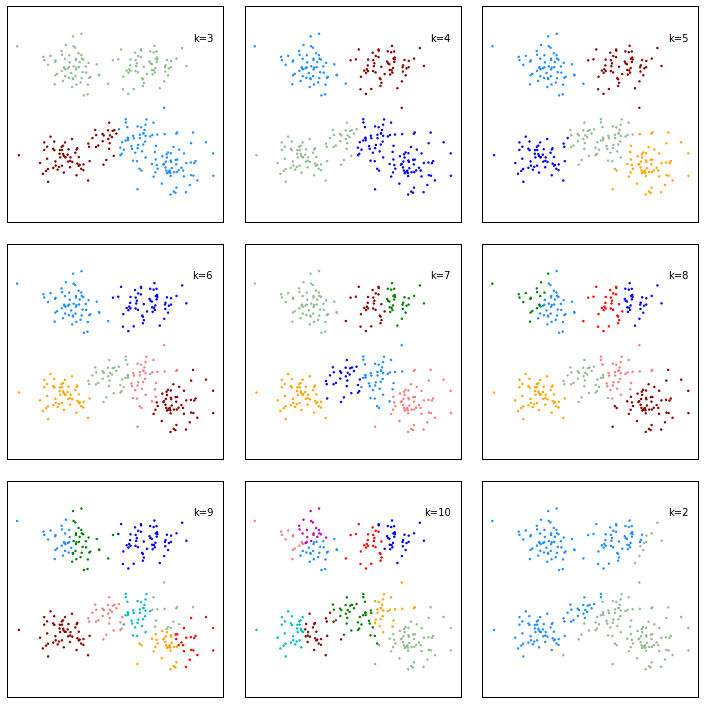

In [68]:
##Cluster Review Figure 5, Panel A
## Ensemble Clustering Toy Example

np.random.seed(0)

n_samples = 300
blobs = datasets.make_blobs(n_samples=n_samples, random_state=10,centers=5,cluster_std=2)

clustcolors = np.array(['darkseagreen','dodgerblue','darkred','b','orange','lightcoral','g','r','c','m','y'])
clustcolors = np.hstack([clustcolors] * 200)

clustering_names = ['k=2','k=3','k=4','k=5','k=6','k=7','k=8','k=9','k=10']

fig=plt.figure(figsize=(10,10))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.1,
                    hspace=.1)
X, y = blobs

# normalize dataset for easier parameter selection
X = StandardScaler().fit_transform(X)

# create clustering estimators
kmeans2 = cluster.MiniBatchKMeans(n_clusters=2)
kmeans3 = cluster.MiniBatchKMeans(n_clusters=3)
kmeans4 = cluster.MiniBatchKMeans(n_clusters=4)
kmeans5 = cluster.MiniBatchKMeans(n_clusters=5)
kmeans6 = cluster.MiniBatchKMeans(n_clusters=6)
kmeans7 = cluster.MiniBatchKMeans(n_clusters=7)
kmeans8 = cluster.MiniBatchKMeans(n_clusters=8)
kmeans9 = cluster.MiniBatchKMeans(n_clusters=9)
kmeans10 = cluster.MiniBatchKMeans(n_clusters=10)

clustering_algorithms = [kmeans2,kmeans3,kmeans4,kmeans5,kmeans6,kmeans7,kmeans8,kmeans9,kmeans10]

plot_num=0
for name, algorithm in zip(clustering_names, clustering_algorithms):
    # predict cluster memberships
    #t0 = time.time()
    algorithm.fit(X)
    #t1 = time.time()
    if hasattr(algorithm, 'labels_'):
        y_pred = algorithm.labels_.astype(np.int)
    else:
        y_pred = algorithm.predict(X)

    # plot
    plt.subplot(3, 3, plot_num)

    plt.scatter(X[:, 0], X[:, 1], color=clustcolors[y_pred].tolist(), s=2)

    plt.xlim(-2.5, 2.5)
    plt.ylim(-2.5, 2.5)
    plt.xticks(())
    plt.yticks(())
    plt.axis("equal")
    plt.text(.95, .84, (name),transform=plt.gca().transAxes, size=10,horizontalalignment='right')
    plot_num+=1



#############################################

plt.show()

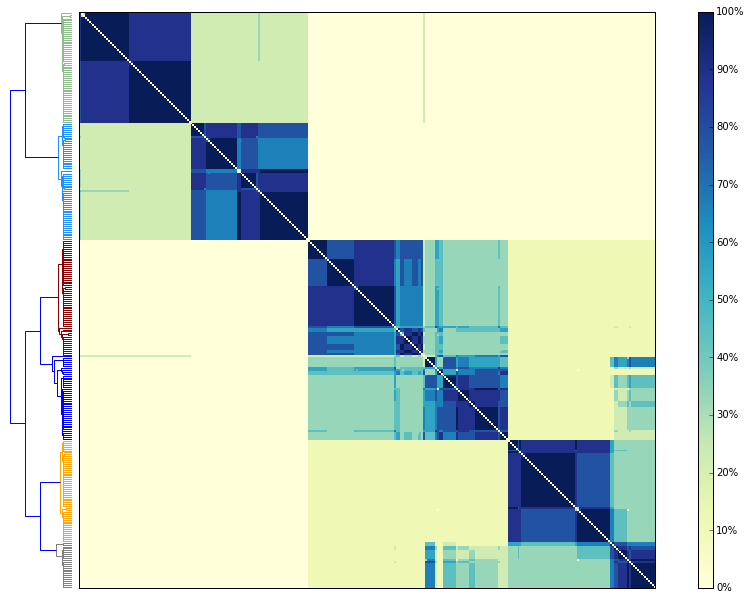

In [69]:
##Cluster Review Figure 5, Panel B
## Ensemble Clustering Toy Example

fig=plt.figure(figsize=(10,10))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.1,
                    hspace=.1)

##############################################################
#co-occurrence matrix
##############################################################
dend_colors=['darkseagreen','dodgerblue','darkred','b','orange','gray','g','r','c','m','y']
sch.set_link_color_palette(dend_colors)


dim=n_samples
co_matrix = np.zeros(shape=(dim,dim))

for algorithm in clustering_algorithms:
    algorithm.fit(X)
    clustering_solution = algorithm.predict(X)
    clusterid_list = np.unique(clustering_solution)
    #print clusterid_list
    for clusterid in clusterid_list:
        itemindex = np.where(clustering_solution==clusterid)
        #print itemindex
        for i,x in enumerate(itemindex[0][0:-2]):
            for j,y in enumerate(itemindex[0][i+1:]):
                #print i,j,x,y
                co_matrix[x,y]+=1
                co_matrix[y,x]+=1

#D=ssd.squareform(co_matrix)
D=co_matrix
dendrogram_distance = 35


# Compute and plot first dendrogram.

#fig = pylab.figure(figsize=(8,8))
ax1 = fig.add_axes([0,0,0.09,0.80])
Y = sch.linkage(D, method='average')
Z1 = sch.dendrogram(Y, orientation='right', color_threshold=dendrogram_distance)
ax1.set_xticks([])
ax1.set_yticks([])
fig.gca().invert_yaxis() # this plus the y-axis invert in the heatmap flips the y-axis heatmap orientation
ax1.axis('off')

# Compute second dendrogram.
Y = sch.linkage(D, method='average')
Z2 = sch.dendrogram(Y, color_threshold=dendrogram_distance, no_plot=True)

# Plot distance matrix.
axmatrix = fig.add_axes([0.10,0,0.80,0.80])
idx1 = Z1['leaves']
idx2 = Z2['leaves']

sorted_co_matrix = co_matrix[idx1,:]
sorted_co_matrix = sorted_co_matrix[:,idx2]
im = axmatrix.matshow(sorted_co_matrix/np.amax(sorted_co_matrix), aspect='auto', origin='lower', cmap=pylab.cm.YlGnBu)
axmatrix.set_xticks([])
axmatrix.set_yticks([])
fig.gca().invert_yaxis() # this plus the x-axis invert in the right-flipped dendrogram flips the y-axis

# Plot colorbar.
axcolor = fig.add_axes([0.96,0,0.02,0.80])
cbar=pylab.colorbar(im, cax=axcolor)
axcolor.tick_params(labelsize=10) 
axcolor.set_yticklabels(['0%','10%','20%','30%','40%','50%','60%','70%','80%','90%','100%',])

plt.show()

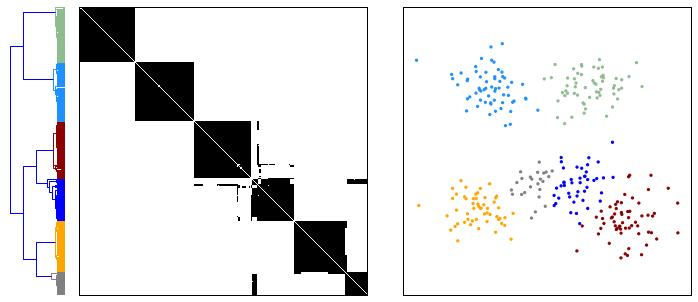

In [70]:
##Cluster Review Figure 5, Panel C
## Ensemble Clustering Toy Example

fig=plt.figure(figsize=(10,10))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.1,
                    hspace=.1)

##############################################################
#thresholded co-occurrence matrix
##############################################################

#D=ssd.squareform(co_matrix)
D=co_matrix
dendrogram_distance = 35

# Compute and plot first dendrogram.
ax3 = fig.add_axes([0,0,0.08,0.40])
Y = sch.linkage(D, method='average')
Z1 = sch.dendrogram(Y, orientation='right', color_threshold=dendrogram_distance)
ax3.set_xticks([])
ax3.set_yticks([])
fig.gca().invert_yaxis() # this plus the y-axis invert in the heatmap flips the y-axis heatmap orientation
ax3.axis('off')

# Compute second dendrogram.
Y = sch.linkage(D, method='average')
Z2 = sch.dendrogram(Y, color_threshold=dendrogram_distance, no_plot=True)


# Plot distance matrix.
axmatrix2 = fig.add_axes([0.10,0,0.40,0.40])
idx1 = Z1['leaves']
idx2 = Z2['leaves']

sorted_co_matrix = co_matrix[idx1,:]
sorted_co_matrix = sorted_co_matrix[:,idx2]
im2 = axmatrix2.matshow(sorted_co_matrix/np.amax(sorted_co_matrix), aspect='auto', origin='lower', cmap=pylab.cm.Greys, vmin=.49, vmax=.51)
axmatrix2.set_xticks([])
axmatrix2.set_yticks([])
fig.gca().invert_yaxis() # this plus the x-axis invert in the right-flipped dendrogram flips the y-axis


##############################################################
#ensemble result
##############################################################

ind = sch.fcluster(Y, dendrogram_distance, 'distance')

axensemble = fig.add_axes([0.55,0,0.4,0.4])
plt.scatter(X[:, 0], X[:, 1], color=np.asarray(dend_colors)[ind-1].tolist(), s=5)
#plt.title("Ensemble Result", size=12)
plt.xlim(-2.5, 2.5)
plt.ylim(-2.5, 2.5)
plt.xticks(())
plt.yticks(())
plt.axis("equal")

plt.show()

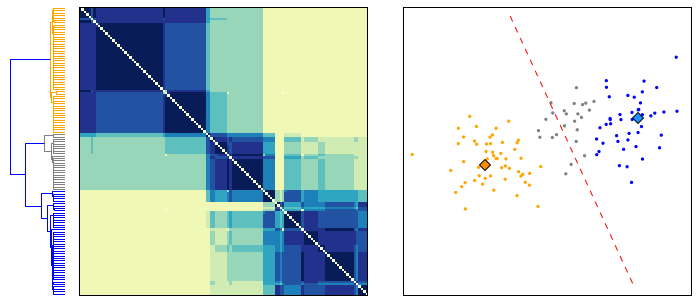

In [74]:
##Cluster Review Figure 5, Panel D
## Ensemble Clustering Toy Example
fig=plt.figure(figsize=(10,10))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.1,
                    hspace=.1)

#############################################
#zoomed co-occ matrix
#############################################

dend_colors=['orange','gray','b','orange','k','k','k']
sch.set_link_color_palette(dend_colors)
khaki_items= ind==4
orange_items = ind==5
blue_items = ind==6
interesting_items = khaki_items + orange_items + blue_items
D2=co_matrix[interesting_items,:]
D2=D2[:,interesting_items]
#dendrogram_distance = 35

# Compute and plot first dendrogram.
ax5 = fig.add_axes([0,0,0.08,0.40])
Y = sch.linkage(D2, method='average')
Z1 = sch.dendrogram(Y, orientation='right', color_threshold=dendrogram_distance)
ax5.set_xticks([])
ax5.set_yticks([])
fig.gca().invert_yaxis() # this plus the y-axis invert in the heatmap flips the y-axis heatmap orientation
ax5.axis('off')

# Compute second dendrogram.
Y = sch.linkage(D2, method='average')
Z2 = sch.dendrogram(Y, color_threshold=dendrogram_distance,no_plot=True)


# Plot distance matrix.
axmatrix3 = fig.add_axes([0.10,0,0.40,0.40])
idx1 = Z1['leaves']
idx2 = Z2['leaves']

sorted_co_matrix = D2[idx1,:]
sorted_co_matrix = sorted_co_matrix[:,idx2]
im3 = axmatrix3.matshow(sorted_co_matrix/np.amax(sorted_co_matrix), aspect='auto', origin='lower', cmap=pylab.cm.YlGnBu, vmin=0, vmax=1)
axmatrix3.set_xticks([])
axmatrix3.set_yticks([])
fig.gca().invert_yaxis() # this plus the x-axis invert in the right-flipped dendrogram flips the y-axis
#axmatrix3.set_title('Zoom')

#plt.text(.95, .90, ('50% Threshold'),transform=plt.gca().transAxes, size=12,horizontalalignment='right')

#Plot colorbar.
#axcolor3 = fig.add_axes([.75,0.2,0.01,0.20])
#cbar=pylab.colorbar(im3, cax=axcolor3)

#############################################
#partially fuzzy result
#############################################
axpf = fig.add_axes([0.55,0,0.4,0.4])
axpf.set_xticks([])
axpf.set_yticks([])

dend_colors=['white','white','white','b','orange','gray','g','r','c','m','y']
sch.set_link_color_palette(dend_colors)

orange_centroid=np.asarray([-1.3,-0.9])
blue_centroid=np.asarray([0.55,-0.4])
plt.scatter(X[:, 0], X[:, 1], color=np.asarray(dend_colors)[ind-1].tolist(), s=5)
plt.scatter(orange_centroid[0],orange_centroid[1],marker='D',edgecolor = 'k',color='darkorange',s=60) # centroid orange
plt.scatter(blue_centroid[0],blue_centroid[1],marker='D',edgecolor = 'k',color='dodgerblue',s=60) # centroid blue

# equidistant line from centroids
plt.plot([-1, 0.5],[0.7,-2.2],'--r')


#plt.title("Partially Fuzzy Result", size=12)
plt.xlim(-2.3, 1.2)
plt.ylim(-2.3, 0.8)
plt.xticks(())
plt.yticks(())

plt.show()

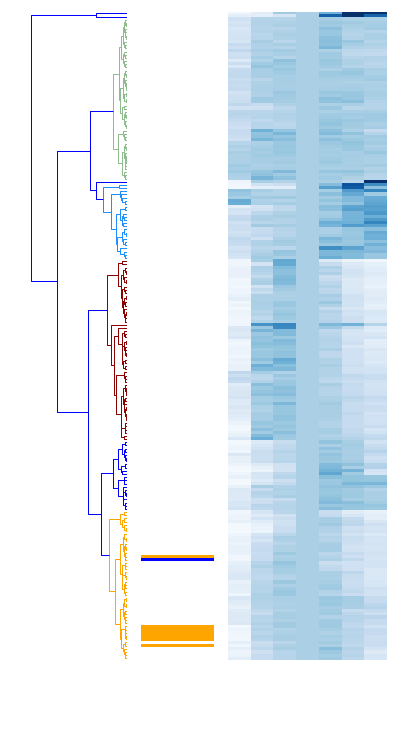

In [86]:
##Cluster Review Figure 6, Panel A
## Ensemble Clustering Example
plt.rcParams['lines.linewidth'] = 1

dend_colors=['darkseagreen','dodgerblue','darkred','b','orange','gray','g','r','c','m','y']
sch.set_link_color_palette(dend_colors)

D = raw_phosprot
row_labels = D.index.get_level_values('gene_site')
fig = pylab.figure(figsize=(5,10))

panel1 = fig.add_axes([0,0,1,1])
panel1.axis('off')
#panel1.set_title('Single\nClustering Solution',y=1.05)

## panel 1
cluster_list = ['EGFR_Y1172', 'EGFR_Y1197', 'GAB1_Y659', 'GAB1_Y627', 'SHC1_Y427', 'SHC1_Y349_Y350', 'CDV3_Y244', 'PDLIM1_Y321']

# Compute and plot left dendrogram, clustering phospho-dynamics
ax1 = add_subplot_axes(panel1,[0.0,0.1,0.28,0.9])
lnk1 = sch.linkage(D, method='ward',metric='euclidean')
Z_pp = sch.dendrogram(lnk1, orientation='right',color_threshold=3)
idx_pp = Z_pp['leaves']
fig.gca().invert_yaxis() # must couple with matshow origin='upper', below, to match Lu(2005) Fig S4
ax1.set_xticks([])
for side in ['top','right','bottom','left']:
    ax1.spines[side].set_visible(False)
ax1.axis('off')


# plot heatmap
axmatrix = add_subplot_axes(panel1,[0.56,0.1,0.44,0.9])
hm = D
hm = hm.ix[idx_pp,:]
im = axmatrix.matshow(hm, aspect='auto', origin='upper', cmap='Blues', vmin = 0, vmax = 3)
#axmatrix.axis('off')
for side in ['top','right','bottom','left']:
    axmatrix.spines[side].set_visible(False)
axmatrix.set_xticks([])
axmatrix.set_xticklabels([])
axmatrix.set_yticks([])

# Add color strip to indicate MAL type (Normal, Tumor or TCL)
ax2 = add_subplot_axes(panel1,[0.32,0.1,0.20,0.9])
list_vals = [0 if any(pp in val for pp in cluster_list) else 1 for val in row_labels]
unsorted_list = np.array(list_vals)
unsorted_list[row_labels == 'PDLIM1_Y321']=2
sorted_list= unsorted_list[np.array(idx_pp)]
ax2.matshow(sorted_list[None].T, aspect='auto', origin='upper', cmap = colors.ListedColormap(['orange','white','blue']))
ax2.set_xticks([])
ax2.set_yticks([])
ax2.axis('off')

plt.show()


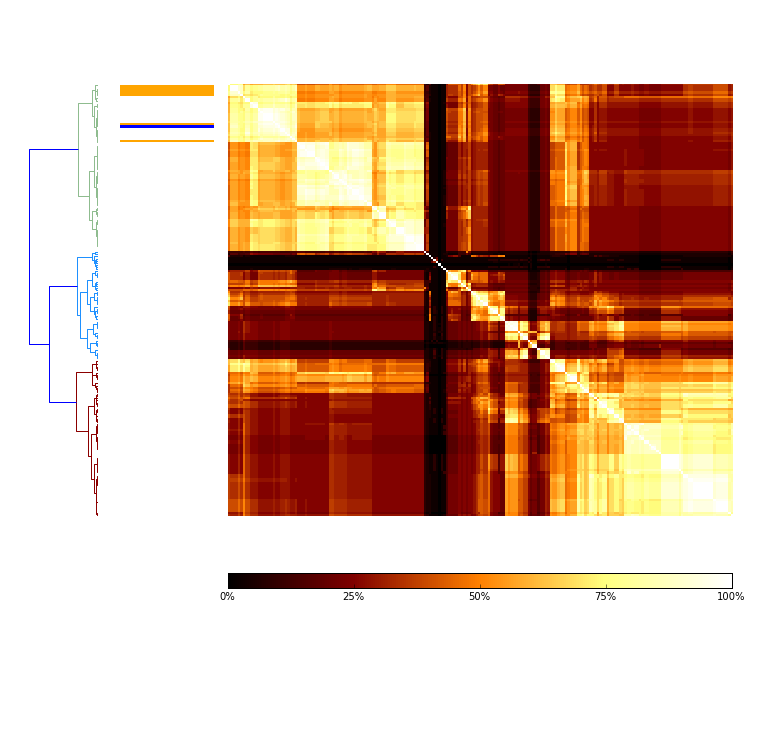

In [87]:
##Cluster Review Figure 6, Panel B
## Ensemble Clustering Example

fig = pylab.figure(figsize=(10,10))
panel3 = fig.add_axes([0,0,1,1])
panel3.axis('off')

## Panel 3

D = raw_phosprot
row_labels = D.index.get_level_values('gene_site')
cluster_list = ['EGFR_Y1172', 'EGFR_Y1197', 'GAB1_T659', 'GAB1_Y627', 'SHC_Y427', 'SHC_Y349_Y350', 'CDV3_Y244', 'PDLIM1_Y321']

dist_metrics = ['euclidean', 'correlation', 'cityblock', 'cosine', 'braycurtis', 'canberra', 'chebyshev', 'sqeuclidean']
bool_dist_metrics = ['dice', 'jaccard', 'kulsinski', 'matching', 'rogerstanimoto', 'russellrao', 'sokalmichener', 'sokalsneath', 'yule']
lnk_methods = ['single', 'complete', 'average', 'weighted', 'median', 'centroid', 'ward']

final_clust_soln = np.zeros([len(raw_phosprot),len(raw_phosprot)])

for dist_metric in dist_metrics:
    for lnk_method in lnk_methods:

        if (lnk_method == 'ward' or lnk_method == 'centroid' or lnk_method == 'median') and dist_metric != 'euclidean':
            continue
        else:
            lnk1 = sch.linkage(D, method=lnk_method, metric = dist_metric)

        ## define clusters here
        
        k=14
        cluster_soln = [dist_metric, lnk_method,fcluster(lnk1, k, criterion='maxclust')]

        
        bin_clust_soln = np.zeros((max(cluster_soln[2]),len(cluster_soln[2])))
        
        for i,entry in enumerate(cluster_soln[2]):
            bin_clust_soln[entry-1,i] = 1 ## assigns 1 to category column, corrected for zero-indexed

        coocc_single = bin_clust_soln.T.dot(bin_clust_soln)
        final_clust_soln = final_clust_soln + coocc_single

final_clust_soln_df = pd.DataFrame(final_clust_soln.astype(int))
# these are separate,  not in creation clause, due to super odd floating point errors
final_clust_soln_df.index = row_labels
final_clust_soln_df.columns = row_labels


D = final_clust_soln_df
row_labels = D.index.get_level_values('gene_site')


cluster_list = ['EGFR_Y1172', 'EGFR_Y1197', 'GAB1_Y659', 'GAB1_Y627', 'SHC1_Y427', 'SHC1_Y349_Y350', 'CDV3_Y244', 'PDLIM1_Y321']

# Compute and plot left dendrogram
ax1 = add_subplot_axes(panel3,[0.0,0.3,0.10,.6])
lnk1 = sch.linkage(D, method='ward',metric='euclidean')
Z_pp = sch.dendrogram(lnk1, orientation='right')
idx_pp = Z_pp['leaves']
#ax1.set_yticklabels(row_labels[idx_pp],size=3)
ax1.set_yticks([])
fig.gca().invert_yaxis() # must couple with matshow origin='upper', below, to match Lu(2005) Fig S4
ax1.set_xticks([])
for side in ['top','right','bottom','left']:
    ax1.spines[side].set_visible(False)
#ax1.axis('off')


# plot heatmap
axmatrix = add_subplot_axes(panel3,[0.28,0.3,0.7,.6])
hm = D.divide(35)
hm = hm.ix[idx_pp,idx_pp]
im = axmatrix.matshow(hm, aspect='auto', origin='upper', cmap='afmhot')
axmatrix.axis('off')

# Add color strip to indicate PDLIM1 cluster presence
ax2 = add_subplot_axes(panel3,[0.13,0.3,0.13,0.6])
list_vals = [0 if any(pp in val for pp in cluster_list) else 1 for val in row_labels]
unsorted_list = np.array(list_vals)
unsorted_list[row_labels == 'PDLIM1_Y321']=2
sorted_list= unsorted_list[np.array(idx_pp)]
ax2.matshow(sorted_list[None].T, aspect='auto', origin='upper', cmap = colors.ListedColormap(['orange','white','blue']))
ax2.set_xticks([])
ax2.set_yticks([])
ax2.axis('off')

# Plot colorbar indicating scale
axcolor = add_subplot_axes(panel3,[0.28,0.2,0.7,.02]) # [xmin, ymin, dx, and dy]
h=pylab.colorbar(im, cax=axcolor,orientation='horizontal')
h.ax.tick_params(labelsize=10)
h.set_ticks([0,.25,.50,.75,1])
h.set_ticklabels(['0%','25%','50%','75%','100%'])

plt.show()


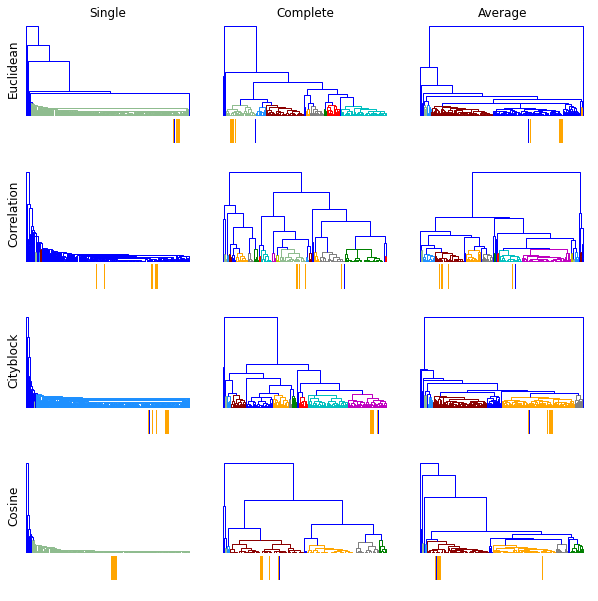

In [88]:
##Cluster Review Figure 6, Panel C
## Ensemble Clustering Example

fig = pylab.figure(figsize=(10,10))

## panel 2

D = raw_phosprot
row_labels = D.index.get_level_values('gene_site')
cluster_list = ['EGFR_Y1172', 'EGFR_Y1197', 'GAB1_Y659', 'GAB1_Y627', 'SHC1_Y427', 'SHC1_Y349_Y350', 'CDV3_Y244', 'PDLIM1_Y321']

dist_metrics = ['euclidean', 'correlation', 'cityblock', 'cosine']
lnk_methods = ['single', 'complete', 'average']


plotnum = 1
for dist_metric in dist_metrics:
    for lnk_method in lnk_methods:
        #make subplot
        panel2 = fig.add_subplot(len(dist_metrics),len(lnk_methods),plotnum)
        panel2.axis('off')

        # Add dendrogram axis
        subpos = [0.0,0.22,1,0.78]
        subax1 = add_subplot_axes(panel2,subpos)
        lnk1 = sch.linkage(D, method=lnk_method, metric = dist_metric)
        Z = sch.dendrogram(lnk1,color_threshold = 0.15*max(lnk1[:,2]))
        idx_leaves = Z['leaves']
        subax1.set_xticks([])
        subax1.set_yticks([])
        subax1.spines['top'].set_visible(False)
        subax1.spines['right'].set_visible(False)
        subax1.spines['bottom'].set_visible(False)
        subax1.spines['left'].set_visible(False)


        if plotnum in [1,2,3]:
            subax1.set_title(lnk_method.title(),size=12)
        if plotnum in [1,4,7,10]:
            subax1.set_ylabel(dist_metric.title(),size=12)

        # Add color strip axis
        subpos = [0,0,1,0.2]
        subax2 = add_subplot_axes(panel2,subpos)
        list_vals = [0 if any(pp in val for pp in cluster_list) else 1 for val in row_labels]
        unsorted_list = np.array(list_vals)
        unsorted_list[row_labels == 'PDLIM1_Y321']=2
        sorted_list= unsorted_list[np.array(idx_leaves)]
        subax2.matshow([sorted_list], aspect='auto', origin='lower', cmap = colors.ListedColormap(['orange','white','blue']))
        subax2.set_xticks([])
        subax2.set_yticks([])
        subax2.axis('off')
        plotnum+=1

plt.show()